In [1]:
WORKING_ON_COLAB = True

if WORKING_ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATASET_FILE_PATH = '/content/drive/My Drive/Projects/IRBoardGameComplexity/dataset.csv'
    !pip install fastcoref==2.0.*
else:
    DATASET_FILE_PATH = 'data/dataset.csv'

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 7.5 MB/s 
     |████████████████████████████████| 441 kB 68.3 MB/s 
     |████████████████████████████████| 1.9 MB 43.8 MB/s 
     |████████████████████████████████| 212 kB 50.0 MB/s 
     |████████████████████████████████| 95 kB 4.7 MB/s 
     |████████████████████████████████| 163 kB 60.2 MB/s 
     |████████████████████████████████| 115 kB 46.8 MB/s 
     |████████████████████████████████| 127 kB 61.0 MB/s 
     |████████████████████████████████| 7.6 MB 33.2 MB/s 
     |████████████████████████████████| 182 kB 59.4 MB/s 
     |████████████████████████████████| 166 kB 60.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 166 kB 59.0 MB/s 
     |████████████████████████████████| 162 kB 38.6 MB/s 
     |████████████████████████████████| 162 kB 59.6 MB/s 
     |████

In [ ]:

from fastcoref import spacy_component
import spacy

nlp = spacy.load("en_core_web_sm", exclude=["parser", "lemmatizer", "ner", "textcat"])
nlp.add_pipe("fastcoref")

Downloading:   0%|          | 0.00/819 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/393 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/362M [00:00<?, ?B/s]

In [ ]:
import logging

logger = logging.getLogger('bgg_predict')
logger.handlers.clear()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

logger.debug('test')

In [ ]:
import re
from typing import List
from dataclasses import dataclass

regex_mail = re.compile(r'\w+(?:\.\w+)*?@\w+(?:\.\w+)+')

@dataclass
class Sentence:
    content: str
    start: int
    end: int
    
    def does_include_pos(self, pos: int) -> bool:
        return self.start <= pos <= self.end

def clean_text(text: str) -> str:
    return regex_mail.sub('', text)

def get_sentences_from_text(text: str) -> List[Sentence]:
    # assert no continuous dots because of text cleared while building the dataset
    sentences = text.split('.')
    
    res = []
    char_accumulator = 0
    for sentence in sentences:
        res.append(Sentence(sentence, char_accumulator, char_accumulator + len(sentence) - 1))
        char_accumulator += len(sentence) + 1
        
    if res[-1].content == '':
        res.pop()
        
    return res

In [ ]:
if WORKING_ON_COLAB:
    # from https://github.com/python/cpython/blob/main/Lib/bisect.py#L68
    def bisect_left(a, x, lo=0, hi=None, *, key=None):
        if hi is None:
            hi = len(a)
        # Note, the comparison uses "<" to match the
        # __lt__() logic in list.sort() and in heapq.
        if key is None:
            while lo < hi:
                mid = (lo + hi) // 2
                if a[mid] < x:
                    lo = mid + 1
                else:
                    hi = mid
        else:
            while lo < hi:
                mid = (lo + hi) // 2
                if key(a[mid]) < x:
                    lo = mid + 1
                else:
                    hi = mid
        return lo
else:
    from bisect import bisect_left
from typing import List, Tuple
from dataclasses import dataclass

# necessary to use bisect_left with ranges
@dataclass
class Interval:
    start: int
    end: int
    
    def __lt__(self, other) -> bool:
       return self.start < self.end < other.start
    
    def __eq__(self, other) -> bool:
       return self.start <= other.start <= self.end

def get_sentences_from_clusters(clusters: List[List[Tuple[int, int]]], sentences: List[Sentence]) -> List[List[int]]:
    '''find the sentence each cluster belongs to'''
    sentence_clusters = []
    for cluster in clusters:
        sentence_clusters.append([bisect_left(sentences, Interval(entity[0], entity[1]), key=lambda x: Interval(x.start, x.end)) for entity in cluster])

    return sentence_clusters

text = 'Alice goes down the rabbit hole. Where she would discover a new reality beyond her expectations.'
sentences = get_sentences_from_text(text)
clusters = [[(0, 5), (39, 42), (79, 82)]]
get_sentences_from_clusters(clusters, sentences)

[[0, 1, 1]]

In [ ]:
from typing import List, Set
from itertools import groupby
from operator import itemgetter
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

def get_rule_groups_from_sentence_clusters(sentences: List[Sentence], sentence_clusters: List[List[int]]) -> List[List[int]]:
    def normalize_group(group: Set[int]) -> List[List[int]]:
        '''each group could contain multiple consecutive sublists. this method split these sublists'''
        res = []

        # https://stackoverflow.com/a/23861347/5587393
        for k, g in groupby(enumerate(sorted(list(group))), lambda x: x[0] - x[1]):
            res.append(list(map(itemgetter(1), g)))

        return res
    # the graph is built as a directed sparse graph where the first element of each cluster
    # is connected to the other elements in the same cluster
    graph = [[0 for _ in range(len(sentences))] for __ in range(len(sentences))]
    for cluster in sentence_clusters:
        for sentence in cluster[1:]:
            graph[cluster[0]][sentence] = 1

    # find the connected components of the graph created from the clusters returned after coref     
    graph = csr_matrix(graph)
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    groups = [set() for _ in range(n_components)]
    for i, label in enumerate(labels):
        groups[label].add(i)

    return [norm_group for group in groups for norm_group in normalize_group(group)]

In [ ]:
import itertools
from typing import List, Tuple
import pandas as pd

def get_rules(text: str) -> List[str]:
    text = clean_text(text)
    sentences = get_sentences_from_text(text)
    
    doc = nlp(text, component_cfg = { "fastcoref": {'resolve_text': True} })
    coref_clusters = doc._.coref_clusters
    logger.debug(coref_clusters)
    
    sentence_clusters = get_sentences_from_clusters(coref_clusters, sentences)
    rule_groups = get_rule_groups_from_sentence_clusters(sentences, sentence_clusters)
    
    return ['. '.join([sentences[s_index].content for s_index in group]) for group in rule_groups]

def get_rules_features(text: str) -> Tuple[int, float]:
    rules = get_rules(text)
    rule_count = len(rules)
    return rule_count, len(text) / rule_count

def remove_columns_prefix(df: pd.core.frame.DataFrame) -> None:
    '''remove prefix 'info.' from the columns of df'''
    df.rename(columns=lambda c: c.rsplit('.', 1)[-1], inplace=True)
    
df_features = pd.DataFrame()
with pd.read_csv(DATASET_FILE_PATH, chunksize=5) as reader:
    for df in reader:
        remove_columns_prefix(df)
        df_rules_features = df.apply(lambda x: pd.Series(get_rules_features(x.rulebook), 
                                     index=['rule_count', 'avg_rule_len']), axis='columns')
        df_features = pd.concat([df_features, df[['numweights', 'averageweight', 'playingtime', 'family']].join(df_rules_features)])
        
display(df_features)
PROCESSED_DATASET_FILE_PATH = '/content/drive/My Drive/Projects/IRBoardGameComplexity/processed_dataset.csv' if WORKING_ON_COLAB \
    else 'data/processed_dataset.csv'

df_features.to_csv(PROCESSED_DATASET_FILE_PATH, header=True, index=False, mode='w')    
if WORKING_ON_COLAB:
    drive.flush_and_unmount()

In [35]:
WORKING_ON_COLAB = True

import pandas as pd
PROCESSED_DATASET_FILE_PATH = '/content/drive/My Drive/Projects/IRBoardGameComplexity/processed_dataset.csv' if WORKING_ON_COLAB \
    else 'data/processed_dataset.csv'

if WORKING_ON_COLAB:
    drive.mount('/content/drive')
import ast
# as.literal_eval converts the family column string into a python array
df_features = pd.read_csv(PROCESSED_DATASET_FILE_PATH, converters={ 'family': ast.literal_eval })

# from https://stackoverflow.com/questions/71401193/one-hot-encoding-in-python-for-array-values-in-a-dataframe
df_features = df_features.join(df_features.pop('family').apply('|'.join).str.get_dummies())
df_features.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,averageweight,playingtime,rule_count,avg_rule_len,familygames,partygames,strategygames,thematic
0,2.1579,60,35.0,90.371429,1,0,0,0
1,3.1452,90,438.0,166.388128,0,0,1,0
2,1.8100,90,94.0,210.553191,0,0,0,1
3,1.4858,30,119.0,120.487395,1,0,0,0
4,2.7813,120,27.0,137.259259,0,0,1,0


In [36]:
TRAIN_PERCENT = 0.75
DATASET_SIZE = len(df_features)
TRAIN_SET_SIZE = int(DATASET_SIZE * TRAIN_PERCENT)

y_train, x_train = df_features.iloc[:TRAIN_SET_SIZE, 0], df_features.iloc[:TRAIN_SET_SIZE, 1:]
y_test, x_test = df_features.iloc[TRAIN_SET_SIZE:, 0], df_features.iloc[TRAIN_SET_SIZE:, 1:]

In [50]:
class Model:
    def __init__(self, instance):
        self.instance = instance
        self.name = instance.__class__.__name__

,Model,Score
0,LinearRegression,-0.809929
0,LassoCV,-0.305828
0,ElasticNetCV,-0.305828
0,RidgeCV,-2.828776


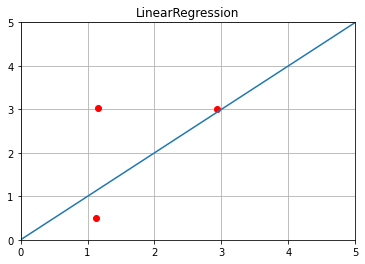

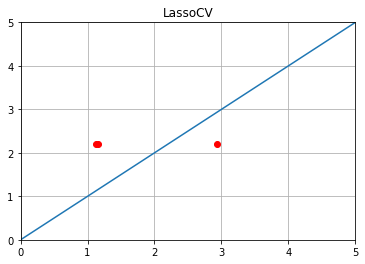

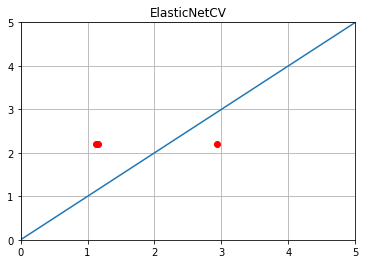

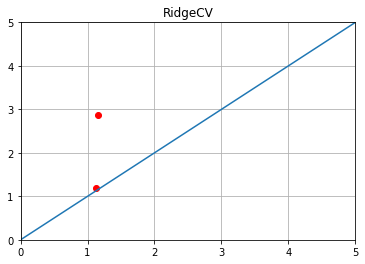

In [59]:
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score

MIN_COMPLEXITY, MAX_COMPLEXITY = 0, 5

def create_graph(index: int, title: str, y_test, predictions) -> None:
    plt.figure(index) 
    plt.title(title)
    plt.axis([MIN_COMPLEXITY, MAX_COMPLEXITY, MIN_COMPLEXITY, MAX_COMPLEXITY])
    plt.grid(True)
    plt.plot(y_test, predictions, 'ro', [MIN_COMPLEXITY, MAX_COMPLEXITY], [MIN_COMPLEXITY, MAX_COMPLEXITY])

models = [
    Model(linear_model.LinearRegression()),
    Model(linear_model.LassoCV()),
    Model(linear_model.ElasticNetCV()),
    Model(linear_model.RidgeCV())
    ]

results = pd.DataFrame(columns=['Model', 'Score'])
for i, model in enumerate(models):
    estimator = model.instance.fit(x_train, y_train)
    predictions = model.instance.predict(x_test)
    results = pd.concat([results, pd.DataFrame([
        { 'Model': model.name, 'Score': r2_score(y_test, predictions) }
        ])])
    create_graph(i, model.name, y_test, predictions)

results